In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix
from lifelines import CoxPHFitter
from sklearn.utils import class_weight
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

In [2]:
df = pd.read_csv("./churn_dataset.csv")

In [3]:
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_ = None  # Will hold fitted column names

    def fit(self, X, y=None):
        # Apply processing once to capture all columns after get_dummies
        X_processed = self._process(X)
        self.columns_ = X_processed.columns
        return self

    def transform(self, X):
        X_processed = self._process(X)
        # Ensure all training-time columns exist, fill missing with 0
        return X_processed.reindex(columns=self.columns_, fill_value=0)
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)
    def _process(self, df):
        df = df.copy()

        for col in ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]:
            if col in df:
                df[col] = df[col].map({"No": 0, "Yes": 1})
        
        internet_cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
        for col in internet_cols:
            if col in df:
                df[col] = df[col].map({"No": 0, "No internet service": 0, "Yes": 1})

        if 'gender' in df:
            df['gender'] = df['gender'].map({"Male": 0, "Female": 1})

        if 'TotalCharges' in df:
            df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].astype(str).str.replace(" ", "0.0"))

        if 'MultipleLines' in df:
            df['MultipleLines'] = df['MultipleLines'].map({"No": 0, "No phone service": 0, "Yes": 1})

        # Drop customerID if present
        df = df.drop(columns=['customerID'], errors='ignore')

        df = pd.get_dummies(df, drop_first=True)
        return df


In [4]:
dp = DataPreprocessor().fit(df)
processed_df = DataPreprocessor().transform(df)

## Classification

In [5]:
X = processed_df.drop("Churn", axis=1)
y = processed_df["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1000)
print(f"{X_train.shape=}, {y_train.shape=}, {X_test.shape=}, {y_test.shape=}")

X_train.shape=(6043, 23), y_train.shape=(6043,), X_test.shape=(1000, 23), y_test.shape=(1000,)


### Logistic Regression

In [6]:
lr = LogisticRegression(max_iter=50000, C=1.0, class_weight='balanced', tol=0.01, random_state=42)
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring="f1")
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f"Model f1 score on Train Dataset: {scores.mean()}")
print(f"Model f1 score on Test Dataset: {f1_score(y_test, y_pred)}")

Model f1 score on Train Dataset: 0.628994009372126
Model f1 score on Test Dataset: 0.6191247974068071


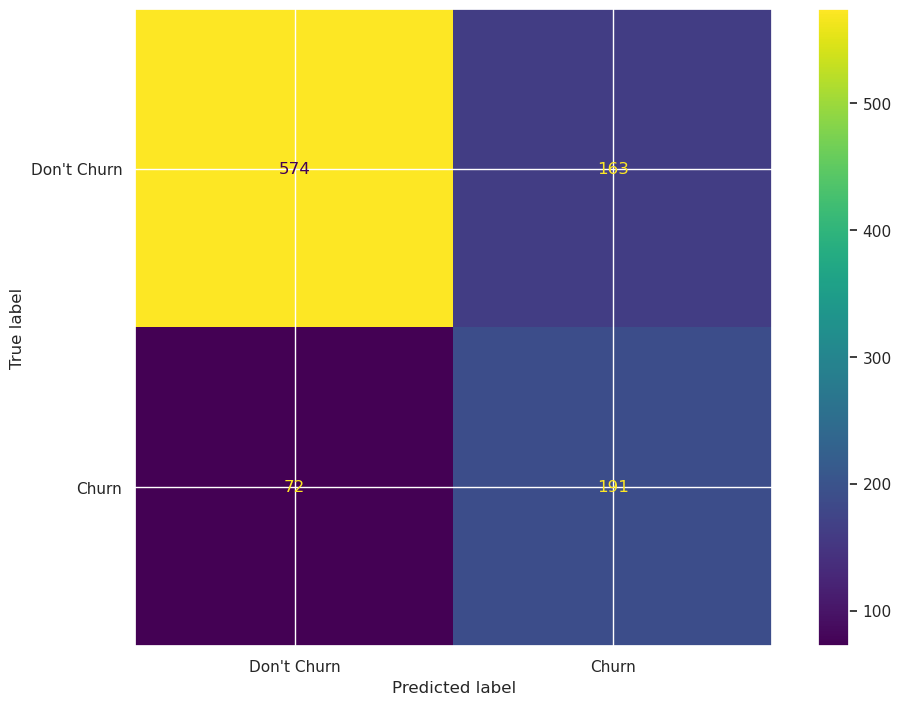

In [7]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm).from_predictions(y_test, y_pred, display_labels=["Don't Churn", "Churn"])
plt.show()

### Random Forest

In [8]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=10, n_jobs=-1, class_weight='balanced', random_state=42)
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring="f1")
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"Model f1 score on Train Dataset: {scores.mean()}")
print(f"Model f1 score on Test Dataset: {f1_score(y_test, y_pred)}")

Model f1 score on Train Dataset: 0.6398932681012182
Model f1 score on Test Dataset: 0.6413223140495867


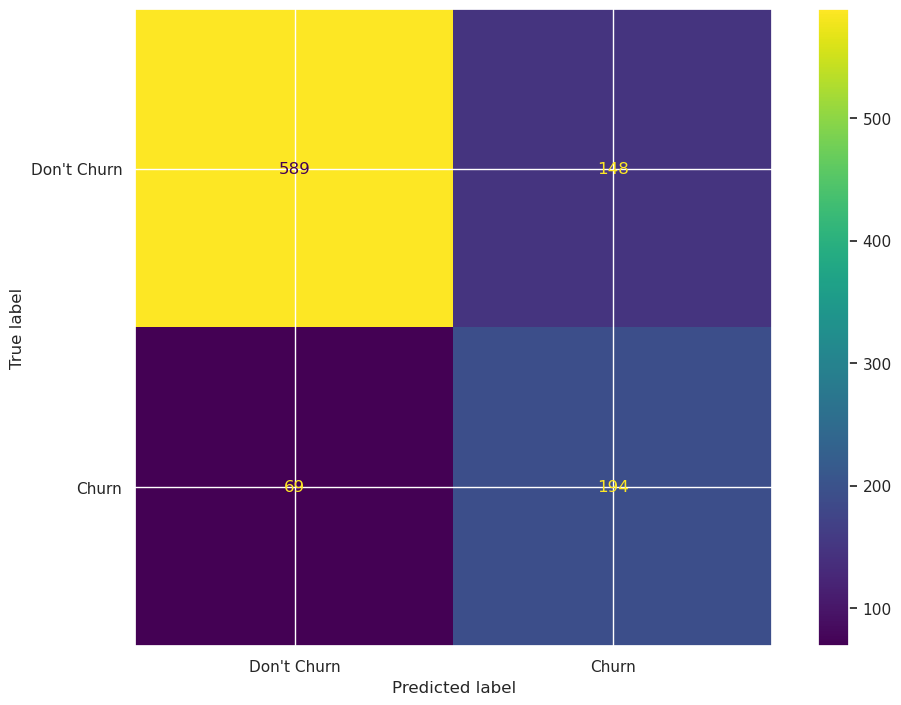

In [9]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm).from_predictions(y_test, y_pred, display_labels=["Don't Churn", "Churn"])
plt.show()

### SVM

In [11]:
svc = SVC(C=50.0, kernel='rbf', class_weight='balanced', random_state=42)
scores = cross_val_score(svc, X_train, y_train, cv=5, scoring="f1", n_jobs=-1)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(f"Model f1 score on Train Dataset: {scores.mean()}")
print(f"Model f1 score on Test Dataset: {f1_score(y_test, y_pred)}")

Model f1 score on Train Dataset: 0.5843090392309815
Model f1 score on Test Dataset: 0.5758998435054773


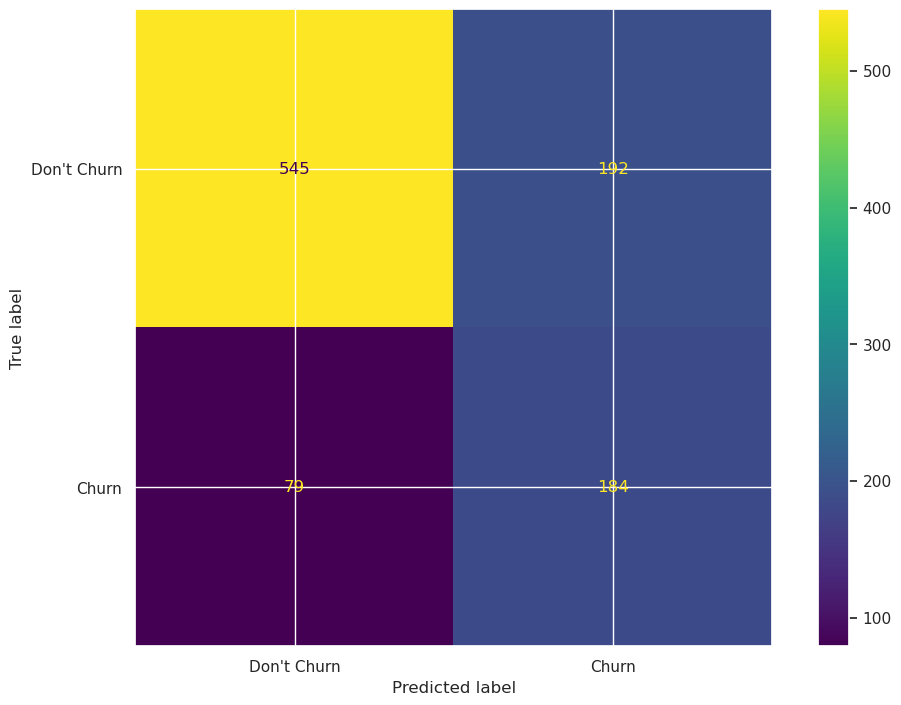

In [12]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm).from_predictions(y_test, y_pred, display_labels=["Don't Churn", "Churn"])
plt.show()

### Gradient Boosting

In [27]:
"""
### Uncoment to search best parameters ###
param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "gamma": [0, 0.1, 0.5],
    "min_child_weight": [1, 3, 5],
    "reg_alpha": [0, 0.1, 1.0],
    "reg_lambda": [1.0, 5.0, 10.0],
    "scale_pos_weight": [1, 3, 5]
}

xgb = XGBClassifier(eval_metric="logloss", random_state=24)

search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=1000,
    scoring="f1",
    cv=5,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train, y_train)
print(search.best_params_)
"""
print()

In [26]:
best_params = {
    'subsample': 0.7, 
    'scale_pos_weight': 3, 
    'reg_lambda': 10.0, 
    'reg_alpha': 0.1, 
    'n_estimators': 200, 
    'min_child_weight': 3, 
    'max_depth': 7, 
    'learning_rate': 0.01, 
    'gamma': 0, 
    'colsample_bytree': 0.7
}
xgb = XGBClassifier(**best_params)
scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring="f1")
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(f"Model f1 score on Train Dataset: {scores.mean()}")
print(f"Model f1 score on Test Dataset: {f1_score(y_test, y_pred)}")

Model f1 score on Train Dataset: 0.631296260736074
Model f1 score on Test Dataset: 0.6381679389312978


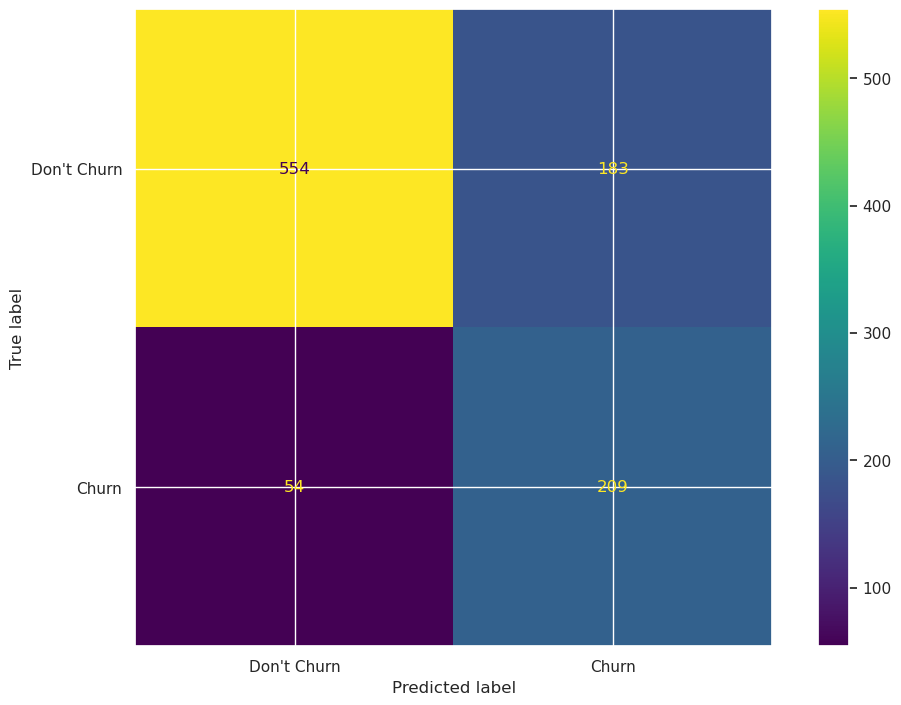

In [28]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm).from_predictions(y_test, y_pred, display_labels=["Don't Churn", "Churn"])
plt.show()

## Survival Analysis

### Cox Regression

In [29]:
train_df, test_df_X, test_df_y = processed_df.iloc[:6043], processed_df.iloc[6043:].drop("Churn", axis=1).reset_index(drop=True), processed_df.iloc[6043:]["Churn"].reset_index(drop=True)

In [30]:
cph = CoxPHFitter()
cph.fit(train_df, duration_col='tenure', event_col='Churn')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 6043 total observations, 4444 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 6043
number of events observed = 1599
   partial log-likelihood = -10566.00
         time fit was run = 2025-06-25 13:34:17 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
gender                                 0.06      1.06      0.05           -0.04            0.16                0.96                1.17
SeniorCitizen                          0.03      1.03      0.06           -0.09            0.15                0.92                1.16
Partner                               -0.16      0.85      0.06           -0.28           -0.04                0.76                0.96
Dependents                            -0.08      0.92      0.08           -0.23            0.07                0.79                1.07
PhoneService                           1.00      2.71      0.51           -0.01            2.00                0.99                7.42
MultipleLines                          0.14      1.15      0.14           -0.13            0.41                0.88                1.50
OnlineSecurity                        -0.17      0.85      0.14           -0.45            0.11                0.64                1.12
OnlineBackup                          -0.00      1.00      0.14           -0.28            0.27                0.76                1.31
DeviceProtection                       0.15      1.16      0.14           -0.12            0.41                0.89                1.51
TechSupport                           -0.05      0.95      0.14           -0.33            0.23                0.72                1.26
StreamingTV                            0.41      1.51      0.26           -0.09            0.92                0.92                2.50
StreamingMovies                        0.39      1.47      0.26           -0.12            0.89                0.89                2.43
PaperlessBilling                       0.16      1.18      0.06            0.04            0.28                1.04                1.33
MonthlyCharges                         0.00      1.00      0.02           -0.05            0.05                0.95                1.05
TotalCharges                          -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
InternetService_Fiber optic            1.32      3.74      0.63            0.09            2.55                1.09               12.85
InternetService_No                    -2.63      0.07      0.65           -3.89           -1.36                0.02                0.26
Contract_One year                     -1.28      0.28      0.11           -1.50           -1.06                0.22                0.35
Contract_Two year                     -3.80      0.02      0.22           -4.24           -3.37                0.01                0.03
PaymentMethod_Credit card (automatic)  0.01      1.01      0.10           -0.18            0.21                0.83                1.23
PaymentMethod_Electronic check         0.42      1.52      0.08            0.26            0.57                1.30                1.78
PaymentMethod_Mailed check             0.53      1.70      0.09            0.35            0.72                1.41                2.05

                                       cmp to      z      p  -log2(p)
covariate                                                            
gender                                   0.00   1.23   0.22      2.19
SeniorCitizen                            0.00   0.52   0.61      0.72
Partner                                  0.00  -2.70   0.01      7.17
Dependents          

#### Analysis

In [31]:
alive = test_df_X[test_df_y==0].reset_index(drop=True).copy()

In [32]:
risk_scores = cph.predict_partial_hazard(alive)
alive['risk'] = risk_scores.values
alive['expected_lifetime'] = cph.predict_expectation(alive)

In [33]:
alive.head().T

,0,1,2,3,4
gender,1,1,1,0,1
SeniorCitizen,0,0,0,0,0
Partner,0,1,0,1,1
Dependents,1,1,0,0,1
tenure,12,38,9,13,47
PhoneService,1,1,1,1,1
MultipleLines,1,0,0,1,0
OnlineSecurity,0,0,0,1,0
OnlineBackup,0,0,0,0,0
DeviceProtection,0,0,1,0,0


In [34]:
least_risk_customer = alive.loc[[alive.risk.idxmin()]]
most_risk_customer = alive.loc[[alive.risk.idxmax()]]

In [35]:
pd.concat([least_risk_customer, most_risk_customer]).T

,537,619
gender,1,0
SeniorCitizen,0,0
Partner,1,0
Dependents,1,0
tenure,72,3
PhoneService,1,1
MultipleLines,1,0
OnlineSecurity,1,0
OnlineBackup,1,0
DeviceProtection,1,1


In [36]:
survival_curves = cph.predict_survival_function(alive)

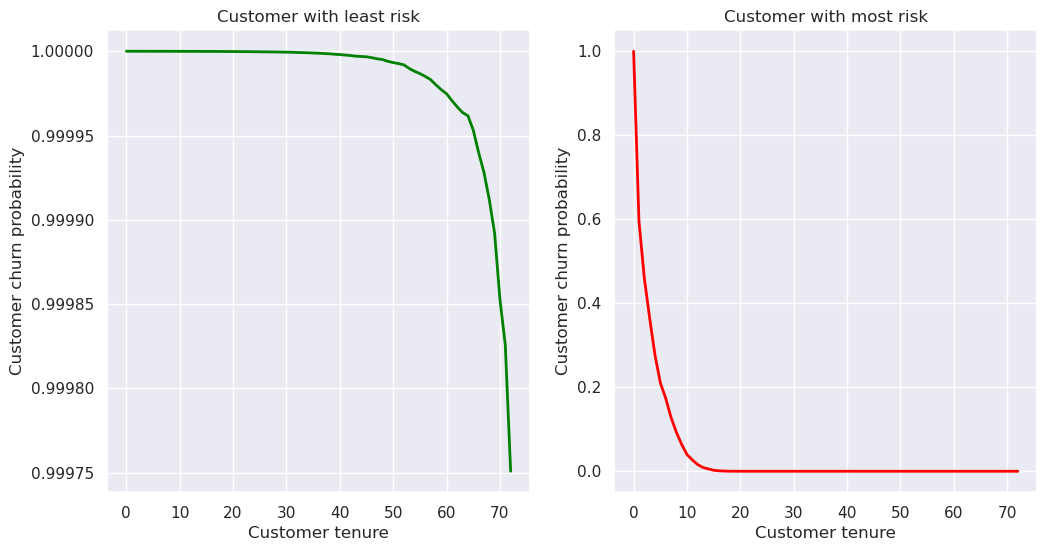

In [37]:
fig, (lrc_ax, mrc_ax) = plt.subplots(ncols=2, nrows=1, figsize=(12, 6))
sns.lineplot(data=survival_curves.iloc[:, least_risk_customer.index[0]], legend=None, color='green', linewidth=2, ax=lrc_ax)
lrc_ax.set_title("Customer with least risk")
lrc_ax.set_xlabel("Customer tenure")
lrc_ax.set_ylabel("Customer churn probability")
sns.lineplot(data=survival_curves.iloc[:, most_risk_customer.index[0]], legend=None, color='red', linewidth=2, ax=mrc_ax)
mrc_ax.set_title("Customer with most risk")
mrc_ax.set_xlabel("Customer tenure")
mrc_ax.set_ylabel("Customer churn probability")
plt.show()

## Prediction

### Form

In [38]:
wide_layout = widgets.Layout(description_width='500px')
gender = widgets.Dropdown(options=['Male', 'Female'], description='Gender')
senior = widgets.Checkbox(value=False, description='SeniorCitizen', disabled=False)
partner = widgets.Checkbox(value=False, description='Partner', disabled=False)
dependents = widgets.Checkbox(value=False, description='Dependents', disabled=False)
paperlessbilling = widgets.Checkbox(value=False, description='PaperlessBilling', disabled=False)

tenure = widgets.IntSlider(min=0, max=72, value=1, description='Tenure')

phoneservice = widgets.Checkbox(value=False, description='PhoneService', disabled=False)
multiplelines = widgets.Checkbox(value=False, description='MultipleLines', disabled=False)

internetservice = widgets.Dropdown(options=['DSL', 'Fiber optic', 'No'], description='InternetService', layout=wide_layout, style={'description_width': 'initial'})
onlinesecurity = widgets.Checkbox(value=False, description='OnlineSecurity', disabled=False)
onlinebackup = widgets.Checkbox(value=False, description='OnlineBackup', disabled=False)
deviceprotection = widgets.Checkbox(value=False, description='DeviceProtection', disabled=False)
techsupport = widgets.Checkbox(value=False, description='TechSupport', disabled=False)
streamingtv = widgets.Checkbox(value=False, description='StreamingTV', disabled=False)
streamingmovies = widgets.Checkbox(value=False, description='StreamingMovies', disabled=False)

contract = widgets.Dropdown(options=['Month-to-month', 'One year', 'Two year'], description='Contract')
paymentmethod = widgets.Dropdown(
    options=['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'],
    description='PaymentMethod', layout=wide_layout, style={'description_width': 'initial'})
monthlycharges = widgets.FloatText(value=70.0, description='MonthlyCharges', layout=wide_layout, style={'description_width': 'initial'})
divider = widgets.HTML(value="<hr>")


In [39]:
button = widgets.Button(description="Predict Churn")
output = widgets.Output()

def on_predict_clicked(b):
    # Create DataFrame from inputs
    checkbox_to_yes_no = lambda value: "Yes" if value else "No"
    data = {
        'gender': [gender.value],
        'SeniorCitizen': [senior.value],
        'Partner': [checkbox_to_yes_no(partner.value)],
        'Dependents': [checkbox_to_yes_no(dependents.value)],
        'tenure': [tenure.value],
        'PhoneService': [checkbox_to_yes_no(phoneservice.value)],
        'MultipleLines': [checkbox_to_yes_no(multiplelines.value)],
        'InternetService': [checkbox_to_yes_no(internetservice.value)],
        'OnlineSecurity': [checkbox_to_yes_no(onlinesecurity.value)],
        'OnlineBackup': [checkbox_to_yes_no(onlinebackup.value)],
        'DeviceProtection': [checkbox_to_yes_no(deviceprotection.value)],
        'TechSupport': [checkbox_to_yes_no(techsupport.value)],
        'StreamingTV': [checkbox_to_yes_no(streamingtv.value)],
        'StreamingMovies': [checkbox_to_yes_no(streamingmovies.value)],
        'Contract': [contract.value],
        'PaperlessBilling': [checkbox_to_yes_no(paperlessbilling.value)],
        'PaymentMethod': [paymentmethod.value],
        'MonthlyCharges': [monthlycharges.value],
        'TotalCharges': [monthlycharges.value*tenure.value],
    }

    df = pd.DataFrame(data)

    # Predict
    with output:
        clear_output()
        preprocessed_df = dp.transform(df)
        
        surv = cph.predict_survival_function(preprocessed_df)
        expected_total = cph.predict_expectation(preprocessed_df).values[0]
        tenure_val = preprocessed_df["tenure"].values[0]
        remaining = expected_total - tenure_val
        expected_total_value = expected_total*preprocessed_df['MonthlyCharges'].values[0]
        expected_remaining_value = remaining*preprocessed_df['MonthlyCharges'].values[0]
        # Ймовірності відтоку
        t_idx = min(surv.index, key=lambda x: abs(x - tenure_val))
        current_surv = surv.loc[t_idx].values[0]
        max_time = surv.index.max()
        p_3 = 1 - surv.loc[min(tenure_val + 3, max_time)].values[0] / current_surv
        p_6 = 1 - surv.loc[min(tenure_val + 6, max_time)].values[0] / current_surv
        p_12 = 1 - surv.loc[min(tenure_val + 12, max_time)].values[0] / current_surv

        # Візуалізація
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(surv.index, surv.values.T[0], label="Survival probability")
        plt.title("Survival function for input customer")
        plt.xlabel("Months since start")
        plt.ylabel("P(survive)")
        plt.ylim(-0.05, 1.05)
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.axis('off')
        info = f"""Expected Total Life: {expected_total:.1f} months
Current Tenure: {tenure_val} months
Expected Remaining: {remaining:.1f} months

Expected Total Value: {expected_total_value:.1f}$
Expected Remaining Value: {expected_remaining_value:.1f}$

Churn Probability in:
- Next 3 months: {p_3*100:.1f}%
- Next 6 months: {p_6*100:.1f}%
- Next 12 months: {p_12*100:.1f}%"""

        plt.text(0, 1, info, fontsize=12, va='top')
        plt.tight_layout()
        plt.show()

button.on_click(on_predict_clicked)

In [40]:
phbox = widgets.HBox([senior, partner, dependents])
bhbox = widgets.HBox([paymentmethod, paperlessbilling])
i1hbox = widgets.HBox([onlinesecurity, onlinebackup, deviceprotection])
i2hbox = widgets.HBox([techsupport, streamingtv, streamingmovies])

personalvbox = widgets.VBox([widgets.HTML(value="<h4>Personal Info</h4>"),gender, phbox, tenure, divider])
phonevbox = widgets.VBox([widgets.HTML(value="<h4>Phone Service</h4>"), phoneservice, multiplelines, divider])
internetvbox = widgets.VBox([widgets.HTML(value="<h4>Internet Service</h4>"), internetservice, i1hbox, i2hbox, divider])
billingvbox = widgets.VBox([widgets.HTML(value="<h4>Billing Information</h4>"), bhbox, contract, monthlycharges, divider])
form = widgets.VBox([personalvbox, phonevbox, internetvbox, billingvbox, button, output])

### Prediction Form

In [41]:
display(form)

To Be Continued